In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\narla\Downloads\Fraud and Risk Project\kaggle\transactions.csv")

df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [2]:
fraud_table = df['isFraud'].value_counts().reset_index()
fraud_table.columns = ['isFraud', 'count']
fraud_table['percentage'] = (fraud_table['count'] / fraud_table['count'].sum()) * 100

from IPython.display import display, Markdown
display(Markdown("### Fraud vs Non-Fraud Transaction Distribution"))
display(fraud_table)
print("\n")

### Fraud vs Non-Fraud Transaction Distribution

,isFraud,count,percentage
0,0,6354407,99.870918
1,1,8213,0.129082


In [3]:
summary_df = pd.DataFrame({
    'Total Transactions': [len(df)],
    'Total Fraud Cases': [df['isFraud'].sum()],
    'Fraud Rate (%)': [round(df['isFraud'].mean() * 100, 4)]
})

from IPython.display import display, Markdown

display(Markdown("### Fraud Risk Summary Overview"))
display(summary_df)
print("\n")

### Fraud Risk Summary Overview

,Total Transactions,Total Fraud Cases,Fraud Rate (%)
0,6362620,8213,0.1291


In [4]:
fraud_by_type = (
    df.groupby('type')['isFraud']
    .mean()
    .mul(100)
    .round(4)
    .reset_index(name='Fraud Rate (%)')
    .sort_values(by='Fraud Rate (%)', ascending=False)
)

from IPython.display import display, Markdown

display(Markdown("### Fraud Rate by Transaction Type"))
display(fraud_by_type)
print("\n")

### Fraud Rate by Transaction Type

,type,Fraud Rate (%)
4,TRANSFER,0.7688
1,CASH_OUT,0.1840
0,CASH_IN,0.0000
2,DEBIT,0.0000
3,PAYMENT,0.0000


In [5]:
fraud_cases_by_type = (
    df.groupby('type')['isFraud']
    .sum()
    .reset_index(name='Total Fraud Cases')
    .sort_values(by='Total Fraud Cases', ascending=False)
)

from IPython.display import display, Markdown

display(Markdown("### Total Fraud Cases by Transaction Type"))
display(fraud_cases_by_type)
print("\n")

### Total Fraud Cases by Transaction Type

,type,Total Fraud Cases
1,CASH_OUT,4116
4,TRANSFER,4097
0,CASH_IN,0
2,DEBIT,0
3,PAYMENT,0


In [6]:
high_value = df[df['amount'] > 200000]

high_value_summary = pd.DataFrame({
    'High Value Threshold': ['> 200,000'],
    'Total Transactions': [len(high_value)],
    'Fraud Cases': [high_value['isFraud'].sum()],
    'Fraud Rate (%)': [round(high_value['isFraud'].mean() * 100, 4)]
})

from IPython.display import display, Markdown

display(Markdown("### High-Value Transaction Risk Analysis"))
display(high_value_summary)
print("\n")

### High-Value Transaction Risk Analysis

,High Value Threshold,Total Transactions,Fraud Cases,Fraud Rate (%)
0,"> 200,000",1673570,5471,0.3269


In [7]:
balance_mismatch = df[
    df['oldbalanceOrg'] - df['amount'] != df['newbalanceOrig']
]

balance_mismatch_summary = pd.DataFrame({
    'Control Test': ['Balance Consistency Check'],
    'Total Transactions with Mismatch': [len(balance_mismatch)],
    'Fraud Cases in Mismatch': [balance_mismatch['isFraud'].sum()],
    'Fraud Rate (%)': [round(balance_mismatch['isFraud'].mean() * 100, 4)]
})

from IPython.display import display, Markdown

display(Markdown("### Balance Consistency Control Weakness Analysis"))
display(balance_mismatch_summary)
print("\n")

### Balance Consistency Control Weakness Analysis

,Control Test,Total Transactions with Mismatch,Fraud Cases in Mismatch,Fraud Rate (%)
0,Balance Consistency Check,5413997,127,0.0023


In [8]:
mismatch_rate_df = pd.DataFrame({
    'Metric': ['Fraud Rate in Balance Mismatch Transactions'],
    'Fraud Rate (%)': [round(balance_mismatch['isFraud'].mean() * 100, 4)]
})

from IPython.display import display, Markdown

display(Markdown("### Fraud Rate for Balance Mismatch Transactions"))
display(mismatch_rate_df)
print("\n")

### Fraud Rate for Balance Mismatch Transactions

,Metric,Fraud Rate (%)
0,Fraud Rate in Balance Mismatch Transactions,0.0023


In [9]:
df['risk_score'] = 0

df.loc[df['amount'] > 200000, 'risk_score'] += 2
df.loc[df['type'] == 'TRANSFER', 'risk_score'] += 1
df.loc[df['oldbalanceOrg'] - df['amount'] != df['newbalanceOrig'], 'risk_score'] += 2
df.loc[df['isFlaggedFraud'] == 1, 'risk_score'] += 3

In [10]:
df['risk_level'] = pd.cut(
    df['risk_score'],
    bins=[-1,1,3,10],
    labels=['Low','Medium','High']
)

In [11]:
risk_distribution = (
    df['risk_level']
    .value_counts()
    .reset_index()
)

risk_distribution.columns = ['Risk Level', 'Transaction Count']

risk_distribution['Percentage (%)'] = (
    risk_distribution['Transaction Count'] /
    risk_distribution['Transaction Count'].sum() * 100
).round(4)

from IPython.display import display, Markdown

display(Markdown("### Risk Level Distribution"))
display(risk_distribution)
print("\n")

### Risk Level Distribution

,Risk Level,Transaction Count,Percentage (%)
0,Medium,3779637,59.4038
1,High,1653965,25.9950
2,Low,929018,14.6012


In [12]:
risk_performance = (
    df.groupby('risk_level', observed=False)['isFraud']
    .mean()
    .mul(100)
    .round(4)
    .reset_index(name='Fraud Rate (%)')
)

from IPython.display import display, Markdown

display(Markdown("### Fraud Rate by Risk Level"))
display(risk_performance)
print("\n")

### Fraud Rate by Risk Level

,risk_level,Fraud Rate (%)
0,Low,0.2938
1,Medium,0.1421
2,High,0.0069


In [13]:
fraud_amount_stats = (
    df.groupby('isFraud')['amount']
    .describe()
    .round(2)
    .reset_index()
)

fraud_amount_stats['isFraud'] = fraud_amount_stats['isFraud'].map({
    0: 'Non-Fraud',
    1: 'Fraud'
})

from IPython.display import display, Markdown

display(Markdown("### Transaction Amount Distribution: Fraud vs Non-Fraud"))
display(fraud_amount_stats)
print("\n")

### Transaction Amount Distribution: Fraud vs Non-Fraud

,isFraud,count,mean,std,min,25%,50%,75%,max
0,Non-Fraud,6354407.0,178197.04,596236.98,0.01,13368.40,74684.72,208364.76,92445516.64
1,Fraud,8213.0,1467967.30,2404252.95,0.00,127091.33,441423.44,1517771.48,10000000.00


In [14]:
median_amount = (
    df.groupby('isFraud')['amount']
    .median()
    .round(2)
    .reset_index(name='Median Transaction Amount')
)

median_amount['isFraud'] = median_amount['isFraud'].map({
    0: 'Non-Fraud',
    1: 'Fraud'
})

from IPython.display import display, Markdown

display(Markdown("### Median Transaction Amount: Fraud vs Non-Fraud"))
display(median_amount)
print("\n")

### Median Transaction Amount: Fraud vs Non-Fraud

,isFraud,Median Transaction Amount
0,Non-Fraud,74684.72
1,Fraud,441423.44


In [15]:
fraud_crosstab = pd.crosstab(
    df['type'],
    df['isFraud']
).reset_index()

fraud_crosstab.columns = [
    'Transaction Type',
    'Non-Fraud Transactions',
    'Fraud Transactions'
]

from IPython.display import display, Markdown

display(Markdown("### Fraud vs Non-Fraud Distribution by Transaction Type"))
display(fraud_crosstab)
print("\n")

### Fraud vs Non-Fraud Distribution by Transaction Type

,Transaction Type,Non-Fraud Transactions,Fraud Transactions
0,CASH_IN,1399284,0
1,CASH_OUT,2233384,4116
2,DEBIT,41432,0
3,PAYMENT,2151495,0
4,TRANSFER,528812,4097


In [16]:
fraud_by_type = (
    df.groupby('type', observed=False)['isFraud']
    .mean()
    .mul(100)
    .round(4)
    .reset_index(name='Fraud Rate (%)')
    .sort_values(by='Fraud Rate (%)', ascending=False)
)

from IPython.display import display, Markdown

display(Markdown("### Fraud Rate Ranking by Transaction Type"))
display(fraud_by_type)
print("\n")

### Fraud Rate Ranking by Transaction Type

,type,Fraud Rate (%)
4,TRANSFER,0.7688
1,CASH_OUT,0.1840
0,CASH_IN,0.0000
2,DEBIT,0.0000
3,PAYMENT,0.0000


### Fraud Case Trend Over Time (by Step)

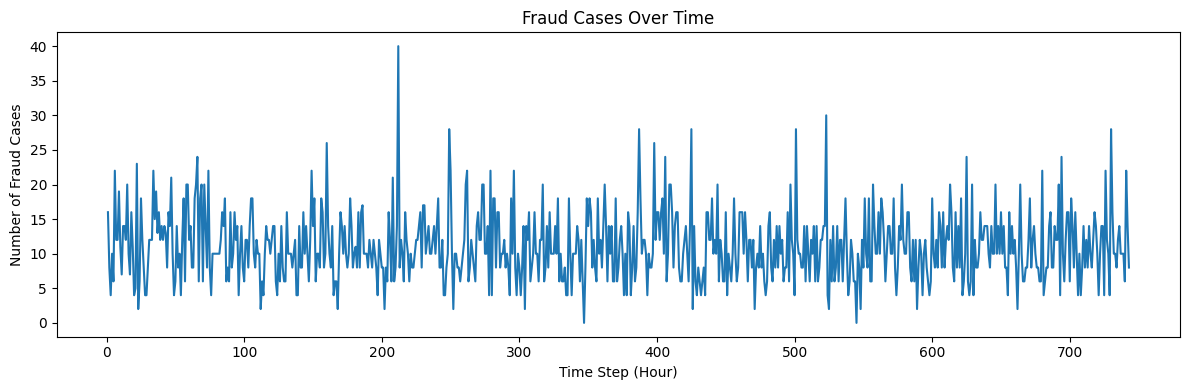

In [17]:
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

fraud_trend = (
    df.groupby('step')['isFraud']
    .sum()
)

display(Markdown("### Fraud Case Trend Over Time (by Step)"))

plt.figure(figsize=(12,4))
plt.plot(fraud_trend)
plt.title("Fraud Cases Over Time")
plt.xlabel("Time Step (Hour)")
plt.ylabel("Number of Fraud Cases")
plt.tight_layout()
plt.show()

print("\n")

### Fraud Rate Trend Over Time (%)

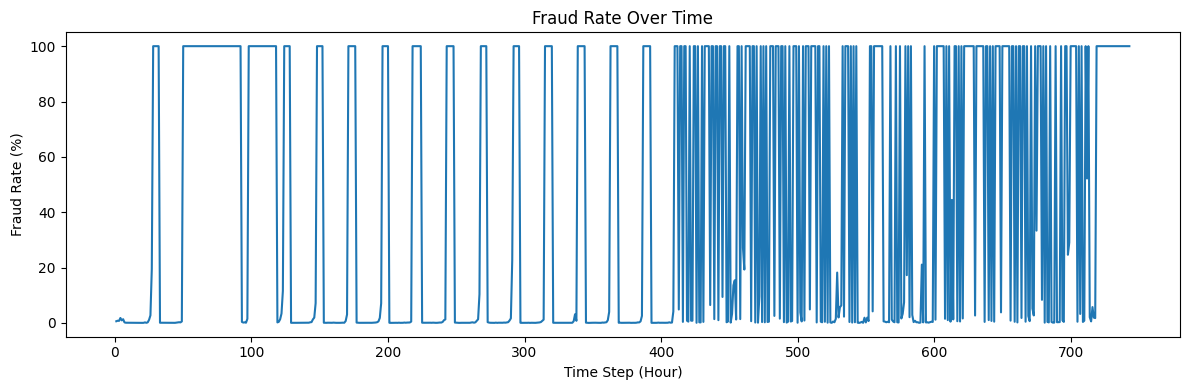

In [18]:
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

fraud_rate_trend = (
    df.groupby('step')['isFraud']
    .mean()
    .mul(100)
)

display(Markdown("### Fraud Rate Trend Over Time (%)"))

plt.figure(figsize=(12,4))
plt.plot(fraud_rate_trend)
plt.title("Fraud Rate Over Time")
plt.xlabel("Time Step (Hour)")
plt.ylabel("Fraud Rate (%)")
plt.tight_layout()
plt.show()

print("\n")

In [19]:
origin_fraud = (
    df.groupby('nameOrig')['isFraud']
    .sum()
    .sort_values(ascending=False)
    .reset_index(name='Total Fraud Cases')
)

top_origin_fraud = origin_fraud.head(10)

from IPython.display import display, Markdown

display(Markdown("### Top 10 Origin Accounts by Fraud Cases"))
display(top_origin_fraud)
print("\n")

### Top 10 Origin Accounts by Fraud Cases

,nameOrig,Total Fraud Cases
0,C1104869047,1
1,C1795788636,1
2,C1526831204,1
3,C1287154806,1
4,C165094398,1
5,C1659569966,1
6,C17491956,1
7,C1720178910,1
8,C1652591304,1
9,C129076810,1


In [20]:
origin_volume = (
    df.groupby('nameOrig')['amount']
    .sum()
    .sort_values(ascending=False)
    .reset_index(name='Total Transaction Amount')
)

top_origin_volume = origin_volume.head(10)

from IPython.display import display, Markdown

display(Markdown("### Top 10 Origin Accounts by Total Transaction Volume"))
display(top_origin_volume)
print("\n")


### Top 10 Origin Accounts by Total Transaction Volume

,nameOrig,Total Transaction Amount
0,C1715283297,92445516.64
1,C2127282686,73823490.36
2,C2044643633,71172480.42
3,C1425667947,69886731.30
4,C1584456031,69337316.27
5,C811810230,67500761.29
6,C420748282,66761272.21
7,C1139847449,64234448.19
8,C300140823,63847992.58
9,C372535854,63294839.63


In [21]:
risk_performance = (
    df.groupby('risk_level', observed=False)['isFraud']
    .mean()
    .mul(100)
    .round(4)
    .reset_index(name='Fraud Rate (%)')
)

from IPython.display import display, Markdown

display(Markdown("### Fraud Rate by Risk Level"))
display(risk_performance)
print("\n")

### Fraud Rate by Risk Level

,risk_level,Fraud Rate (%)
0,Low,0.2938
1,Medium,0.1421
2,High,0.0069


In [22]:
high_risk = df[df['risk_level'] == 'High']

high_risk_summary = pd.DataFrame({
    'Metric': ['High-Risk Fraud Rate'],
    'Fraud Rate (%)': [round(high_risk['isFraud'].mean() * 100, 4)],
    'Total High-Risk Transactions': [len(high_risk)],
    'Fraud Cases in High-Risk': [high_risk['isFraud'].sum()]
})

from IPython.display import display, Markdown

display(Markdown("### High-Risk Bucket Performance Summary"))
display(high_risk_summary)
print("\n")

### High-Risk Bucket Performance Summary

,Metric,Fraud Rate (%),Total High-Risk Transactions,Fraud Cases in High-Risk
0,High-Risk Fraud Rate,0.0069,1653965,114


In [23]:
threshold_txns = df[
    (df['amount'] >= 190000) &
    (df['amount'] < 200000)
]

threshold_summary = pd.DataFrame({
    'Threshold Band': ['190,000 – 199,999'],
    'Total Transactions': [len(threshold_txns)],
    'Fraud Cases': [threshold_txns['isFraud'].sum()],
    'Fraud Rate (%)': [round(threshold_txns['isFraud'].mean() * 100, 4)]
})

from IPython.display import display, Markdown

display(Markdown("### Threshold Band Fraud Analysis (Potential Splitting Behavior)"))
display(threshold_summary)
print("\n")

### Threshold Band Fraud Analysis (Potential Splitting Behavior)

,Threshold Band,Total Transactions,Fraud Cases,Fraud Rate (%)
0,"190,000 – 199,999",98180,64,0.0652


In [24]:
threshold_accounts = (
    threshold_txns
    .groupby('nameOrig')
    .size()
    .sort_values(ascending=False)
    .reset_index(name='Threshold Band Transaction Count')
)

top_threshold_accounts = threshold_accounts.head(10)

from IPython.display import display, Markdown

display(Markdown("### Top 10 Accounts with Repeated Threshold-Band Transactions"))
display(top_threshold_accounts)
print("\n")

### Top 10 Accounts with Repeated Threshold-Band Transactions

,nameOrig,Threshold Band Transaction Count
0,C424465218,2
1,C999712738,1
2,C999701024,1
3,C1000054824,1
4,C99972727,1
5,C999736294,1
6,C999743118,1
7,C999751456,1
8,C999752935,1
9,C999783561,1


In [25]:
df_sorted = df.sort_values(['nameOrig', 'step'])

df_sorted['time_diff'] = df_sorted.groupby('nameOrig')['step'].diff()

In [26]:
rapid_txns = df_sorted[df_sorted['time_diff'] <= 1]

rapid_summary = pd.DataFrame({
    'Rapid Transaction Window': ['<= 1 Hour'],
    'Total Rapid Transactions': [len(rapid_txns)],
    'Fraud Cases': [rapid_txns['isFraud'].sum()],
    'Fraud Rate (%)': [round(rapid_txns['isFraud'].mean() * 100, 4)]
})

from IPython.display import display, Markdown

display(Markdown("### Rapid Sequential Transaction Risk Analysis"))
display(rapid_summary)
print("\n")

### Rapid Sequential Transaction Risk Analysis

,Rapid Transaction Window,Total Rapid Transactions,Fraud Cases,Fraud Rate (%)
0,<= 1 Hour,112,0,0.0


In [27]:
drain_pattern = df[df['newbalanceOrig'] == 0]

drain_summary = pd.DataFrame({
    'Pattern Tested': ['Post-Transaction Balance = 0'],
    'Total Transactions': [len(drain_pattern)],
    'Fraud Cases': [drain_pattern['isFraud'].sum()],
    'Fraud Rate (%)': [round(drain_pattern['isFraud'].mean() * 100, 4)]
})

from IPython.display import display, Markdown

display(Markdown("### Account Drain Pattern Risk Analysis"))
display(drain_summary)
print("\n")

### Account Drain Pattern Risk Analysis

,Pattern Tested,Total Transactions,Fraud Cases,Fraud Rate (%)
0,Post-Transaction Balance = 0,3609566,8053,0.2231


In [28]:
df['risk_score'] = 0

df.loc[df['amount'] > 200000, 'risk_score'] += 2
df.loc[df['type'] == 'TRANSFER', 'risk_score'] += 1
df.loc[df['oldbalanceOrg'] - df['amount'] != df['newbalanceOrig'], 'risk_score'] += 2
df.loc[df['amount'].between(190000,200000), 'risk_score'] += 1
df.loc[df['newbalanceOrig'] == 0, 'risk_score'] += 1

In [29]:
df['risk_level'] = pd.cut(df['risk_score'],
                          bins=[-1,1,3,10],
                          labels=['Low','Medium','High'])

In [30]:
risk_rate_df = (
    df.groupby('risk_level', observed=False)['isFraud']
    .mean()
    .mul(100)
    .round(4)
    .reset_index(name='Fraud Rate (%)')
)

from IPython.display import display, Markdown

display(Markdown("### Fraud Rate by Risk Level"))
display(risk_rate_df)
print("\n")

### Fraud Rate by Risk Level

,risk_level,Fraud Rate (%)
0,Low,0.1446
1,Medium,0.1155
2,High,0.1482


In [31]:
total_txns = len(df)
total_fraud = df['isFraud'].sum()
fraud_rate = df['isFraud'].mean() * 100

high_risk_count = len(df[df['risk_level'] == 'High'])
high_risk_fraud_rate = df[df['risk_level'] == 'High']['isFraud'].mean() * 100

print("Total Transactions:", total_txns)
print("Total Fraud Cases:", total_fraud)
print("Overall Fraud Rate:", round(fraud_rate,4), "%")
print("High Risk Transactions:", high_risk_count)
print("Fraud Rate in High Risk:", round(high_risk_fraud_rate,4), "%")

Total Transactions: 6362620
Total Fraud Cases: 8213
Overall Fraud Rate: 0.1291 %
High Risk Transactions: 1816092
Fraud Rate in High Risk: 0.1482 %


In [32]:
risk_by_type = (
    df.groupby('type', observed=False)
    .agg(
        Total_Transactions=('isFraud','count'),
        Fraud_Cases=('isFraud','sum'),
        Fraud_Rate_Percent=('isFraud','mean')
    )
)

risk_by_type['Fraud_Rate_Percent'] = (
    risk_by_type['Fraud_Rate_Percent'] * 100
).round(4)

risk_by_type = (
    risk_by_type
    .sort_values(by='Fraud_Rate_Percent', ascending=False)
    .reset_index()
)

from IPython.display import display, Markdown

display(Markdown("### Fraud Exposure & Rate by Transaction Type"))
display(risk_by_type)
print("\n")

### Fraud Exposure & Rate by Transaction Type

,type,Total_Transactions,Fraud_Cases,Fraud_Rate_Percent
0,TRANSFER,532909,4097,0.7688
1,CASH_OUT,2237500,4116,0.1840
2,CASH_IN,1399284,0,0.0000
3,DEBIT,41432,0,0.0000
4,PAYMENT,2151495,0,0.0000


In [33]:
high_risk_distribution = (
    df[df['risk_level'] == 'High']
    .groupby('type', observed=False)['isFraud']
    .mean()
    .mul(100)
    .round(4)
    .reset_index(name='Fraud Rate (%)')
    .sort_values(by='Fraud Rate (%)', ascending=False)
)

from IPython.display import display, Markdown

display(Markdown("### Fraud Rate by Transaction Type (High-Risk Bucket Only)"))
display(high_risk_distribution)
print("\n")

### Fraud Rate by Transaction Type (High-Risk Bucket Only)

,type,Fraud Rate (%)
4,TRANSFER,0.5217
1,CASH_OUT,0.0015
0,CASH_IN,0.0000
2,DEBIT,0.0000
3,PAYMENT,0.0000


In [34]:
df.to_csv(r"C:\Users\narla\Downloads\Fraud and Risk Project\fraud_risk_scored.csv", index=False)